In [1]:
from typing import List, Dict, Any
import argparse
import pickle
import datetime
import pandas as pd

import sys
import os
from dotenv import load_dotenv
load_dotenv()
DATA_PATH = os.environ.get("data_path")
sys.path.insert(0, os.getenv('lib_path'))
sys.path.insert(0, os.getenv('root_path'))


from lib.notebook_imports import *
from lib.read_data import read_data
from lib.read_data_2015 import read_data_2015
from lib.consts import get_lgb_params_base, get_n_folds
from lib.data_series import prepare_data_serie, DataSerie
from lib.train import train_data_series, train_fold
from lib.data_filter import DataFilter
from lib.kernels import TherapyPredictorFactory, prepare_therapy_models
from lib.metrics import RMSE
from lib.vcf import (
    read_vcf_files,
    LocusInfo,
    SnipInfo,
    Genome,
    GeneticData,
    prepare_genome_df,
    prepare_hmap_files,
    prepare_phase_files,
    read_mappings,
    read_allele_file,
    prepare_genetic_data,
    read_vcf_files_list,
    read_file_list,
)
from lib.read_haplotypes import (
    read_phase_inp_files,
    read_fastphase_files,
    read_phase_files,
    read_haploview_column,
    read_haploview_data,
    read_haploview_file,
    read_hmap_file,
)

%load_ext autoreload
%autoreload 2

%matplotlib inline


The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.


In [2]:
from dotenv import load_dotenv
load_dotenv()
DATA_PATH = os.environ.get("DATA_PATH")

In [4]:

from lib.prepare_data_for_nn import alter_prot, alter_stim

In [5]:
input_dir = DATA_PATH
output_dir = "C:\\Users\\zielinskik\\Desktop\\3x1\\models"

In [6]:
data_2015_df = read_data_2015(DATA_PATH)

Columns (22,34,43,47,51,57,62,82,238,240) have mixed types.Specify dtype option on import or set low_memory=False.


Data len - before drop_duplicates(process_number): 13084
Data len - after drop_duplicates(process_number): 12892
Data len: 12892
Data len: 12892 after merge with causes
Converting ds_1_result_num_E2 to float
Converting ds_1_result_num_LH to float
Converting ds_1_result_num_PRG to float
Converting ds_1_result_num_AMH to float
Converting amh_qual_result_num to float
Converting qual_result_num_FSH to float
Converting qual_result_num_DHEAS to float
Converting qual_result_num_Inh_B to float
Converting qual_result_num_TST to float
Converting qual_result_num_anty_TPO to float
Converting qual_result_num_TSH to float
Converting qual_result_num_SHBG to float
Converting ds1_3_dawka to float
Converting ds1_7_dawka to float
-
FSH:             low: 8%,  normal: 76%, high: 15%, filled: 42%, (?)
DHEAS:           low: 3%,  normal: 87%, high: 10%, filled: 59%, ()
Inh_B:           low: 30%, normal: 40%, high: 29%, filled: 45%, (faza folikularna)
TST:             low: 54%, normal: 44%, high: 2%, filled: 4

## Place on the distribution

In [38]:
%matplotlib inline

import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.alpha,st.anglit,st.arcsine,st.beta,st.betaprime,st.bradford,st.burr,st.cauchy,st.chi,st.chi2,st.cosine,
        st.dgamma,st.dweibull,st.erlang,st.expon,st.exponnorm,st.exponweib,st.exponpow,st.f,st.fatiguelife,st.fisk,
        st.foldcauchy,st.foldnorm,st.genlogistic,st.genpareto,st.gennorm,st.genexpon,
        st.genextreme,st.gausshyper,st.gamma,st.gengamma,st.genhalflogistic,st.gilbrat,st.gompertz,st.gumbel_r,
        st.gumbel_l,st.halfcauchy,st.halflogistic,st.halfnorm,st.halfgennorm,st.hypsecant,st.invgamma,st.invgauss,
        st.invweibull,st.johnsonsb,st.johnsonsu,st.ksone,st.kstwobign,st.laplace,st.levy,st.levy_l,
        st.logistic,st.loggamma,st.loglaplace,st.lognorm,st.lomax,st.maxwell,st.mielke,st.nakagami,st.ncx2,
        st.norm,st.pareto,st.pearson3,st.powerlaw,st.powerlognorm,st.powernorm,st.rdist,st.reciprocal,
        st.rayleigh,st.rice,st.recipinvgauss,st.semicircular,st.t,st.triang,st.truncexpon,st.truncnorm,st.tukeylambda,
        st.uniform,st.vonmises,st.vonmises_line,st.wald,st.weibull_min,st.weibull_max,st.wrapcauchy
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:
        print('Checking distribution {}'.format(distribution))
        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        pd.Series(pdf, x).plot(ax=ax)
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

In [39]:
data = data_2015_df['day_0_mii'].loc[pd.notna(data_2015_df['day_0_mii'])]

In [40]:
data_fit = data.loc[data<25].copy()

In [633]:
# Find best fit distribution
best_fit_name, best_fit_params = best_fit_distribution(data_fit, 200, ax)
best_dist = getattr(st, best_fit_name)

Checking distribution <scipy.stats._continuous_distns.alpha_gen object at 0x000002065A25A370>
Checking distribution <scipy.stats._continuous_distns.anglit_gen object at 0x000002065A25A6A0>
Checking distribution <scipy.stats._continuous_distns.arcsine_gen object at 0x000002065A25A8E0>
Checking distribution <scipy.stats._continuous_distns.beta_gen object at 0x000002065A25AC40>
Checking distribution <scipy.stats._continuous_distns.betaprime_gen object at 0x000002065A25AEB0>
Checking distribution <scipy.stats._continuous_distns.bradford_gen object at 0x000002065A278100>
Checking distribution <scipy.stats._continuous_distns.burr_gen object at 0x000002065A2783D0>
Checking distribution <scipy.stats._continuous_distns.cauchy_gen object at 0x000002065A278CD0>
Checking distribution <scipy.stats._continuous_distns.chi_gen object at 0x000002065A278940>
Checking distribution <scipy.stats._continuous_distns.chi2_gen object at 0x000002065A2820A0>
Checking distribution <scipy.stats._continuous_distns.

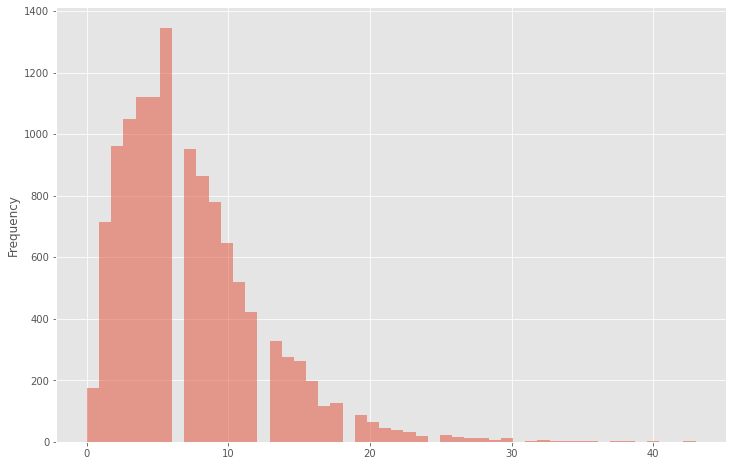

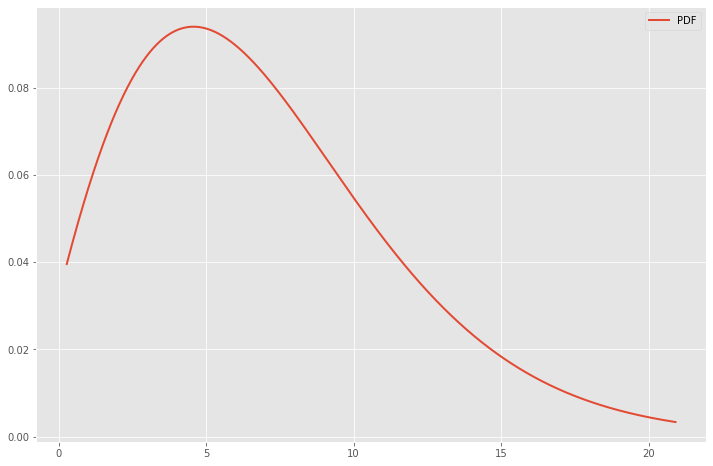

In [634]:
plt.figure(figsize=(12,8))
ax = data.plot(kind='hist', bins=50, alpha=0.5)
# Save plot limits
dataYLim = ax.get_ylim()

# Update plots
ax.set_ylim(dataYLim)


# Make PDF with best params 
pdf = make_pdf(best_dist, best_fit_params)

# Display
plt.figure(figsize=(12,8))
ax = pdf.plot(lw=2, label='PDF', legend=True)


In [635]:
best_fit_params

(0.14868816312646357,
 1.7689834592304505,
 0.3415648889179768,
 -0.004246843238229767,
 4.62071558951822)

In [642]:
best_dist

In [636]:
x = np.linspace(0,40,500)

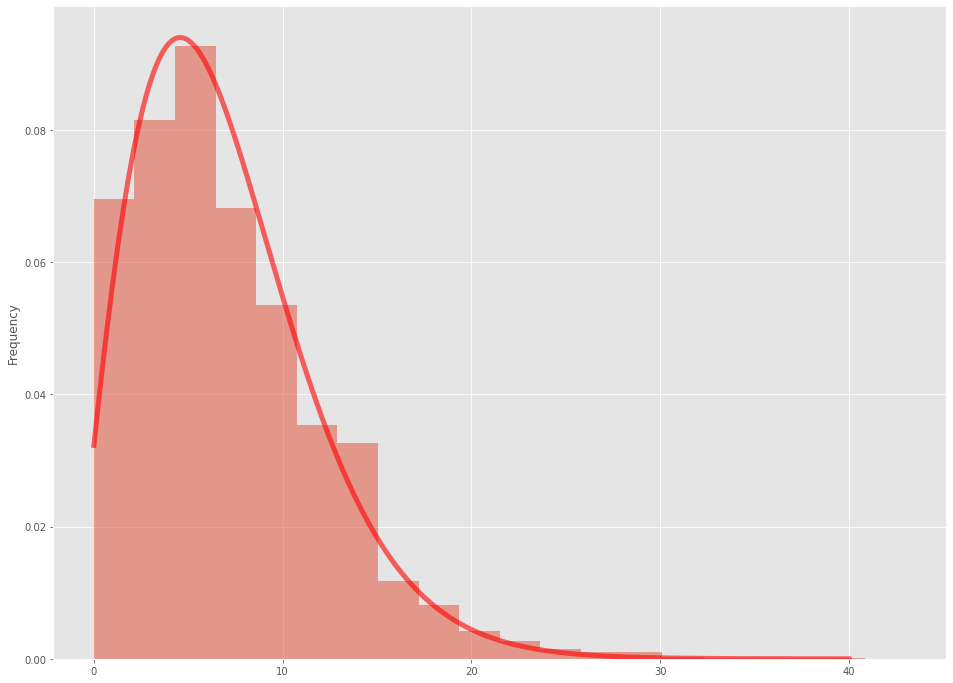

In [637]:
fig, ax = plt.subplots(1, 1)
ax = data.plot(kind='hist', density=True, bins=20, alpha=0.5)
ax.plot(x, best_dist.pdf(x,*best_fit_params),
       'r-', lw=5, alpha=0.6, label='genexpon pdf')

In [746]:
def find_best_fit_params(dist,params,data):
    shifts = list(np.linspace(0.01,0.1,20))
    params = list(params)
    for shift in shifts:
        print("---------------------")
        print('Shifting params - {}'.format(shift))
        params_shifted = params
        params_shifted[3] -=shift
        print('New param value: {}'.format(params_shifted[3]))
        params_shifted = tuple(params_shifted)
        for i in range(15):
            print('approx: {}, actual: {}, diff: {}'.format(
                np.round(dist.cdf(i,*params_shifted),3),
                np.round((data<=i).sum()/data.shape[0],3),
                np.round(np.round(dist.cdf(i,*params_shifted),3)-np.round((data<=i).sum()/data.shape[0],3),3)))

In [747]:
find_best_fit_params(best_dist,best_fit_params,data)

---------------------
Shifting params - 0.01
New param value: -0.014246843238229768
approx: 0.0, actual: 0.014, diff: -0.014
approx: 0.046, actual: 0.072, diff: -0.026
approx: 0.113, actual: 0.15, diff: -0.037
approx: 0.195, actual: 0.235, diff: -0.04
approx: 0.286, actual: 0.325, diff: -0.039
approx: 0.379, actual: 0.416, diff: -0.037
approx: 0.471, actual: 0.525, diff: -0.054
approx: 0.558, actual: 0.602, diff: -0.044
approx: 0.636, actual: 0.671, diff: -0.035
approx: 0.705, actual: 0.734, diff: -0.029
approx: 0.765, actual: 0.786, diff: -0.021
approx: 0.815, actual: 0.828, diff: -0.013
approx: 0.856, actual: 0.863, diff: -0.007
approx: 0.889, actual: 0.889, diff: 0.0
approx: 0.916, actual: 0.911, diff: 0.005
---------------------
Shifting params - 0.01473684210526316
New param value: -0.028983685343492927
approx: 0.001, actual: 0.014, diff: -0.013
approx: 0.047, actual: 0.072, diff: -0.025
approx: 0.114, actual: 0.15, diff: -0.036
approx: 0.196, actual: 0.235, diff: -0.039
approx: 0

In [748]:
best_fit_params_shifted = tuple([best_fit_params[0],best_fit_params[1],best_fit_params[2],-0.4368784221855982,best_fit_params[4]])

In [749]:
list(best_fit_params_shifted)

[0.14868816312646357,
 1.7689834592304505,
 0.3415648889179768,
 -0.4368784221855982,
 4.62071558951822]

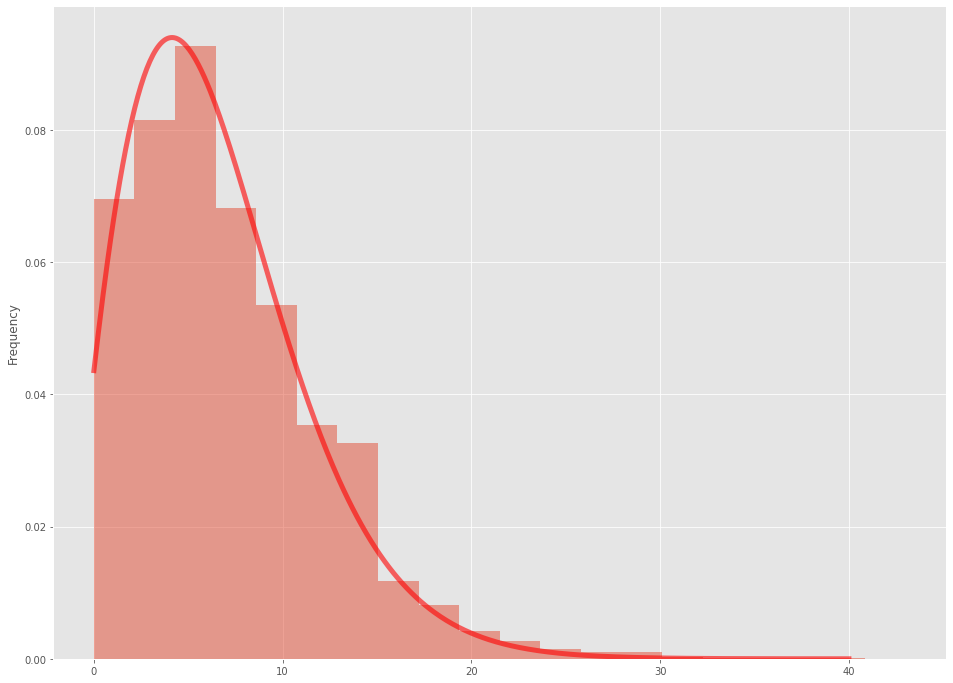

In [750]:
fig, ax = plt.subplots(1, 1)
ax = data.plot(kind='hist', density=True, bins=20, alpha=0.5)
ax.plot(x, best_dist.pdf(x,*best_fit_params_shifted),
       'r-', lw=5, alpha=0.6, label='genexpon pdf')

In [751]:
best_dist.cdf(1,*best_fit_params_shifted)

0.0717397578225418

In [47]:
(data<=2).sum()/data.shape[0]

0.14974947470502667

In [640]:
(data<=8).sum()/data.shape[0]

0.6712461613059642

In [757]:
best_fit_params_shifted

(0.14868816312646357,
 1.7689834592304505,
 0.3415648889179768,
 -0.4368784221855982,
 4.62071558951822)

In [801]:
with open('models/best_dist_with_params.pickle', 'wb') as f:
    pickle.dump(tuple([best_dist,best_fit_params_shifted]), f)

In [41]:
with open('models/best_dist_with_params.pickle', 'rb') as f:
     best_dist_params = pickle.load(f)

In [42]:
best_dist_params[0]

In [43]:
best_dist_params[1]

(0.14868816312646357,
 1.7689834592304505,
 0.3415648889179768,
 -0.4368784221855982,
 4.62071558951822)

In [46]:
best_dist_params[0].cdf(1,*best_dist_params[1])

0.0717397578225418

In [131]:
class distribution_mii:
    def __init__(
        self,
        input_directory):
        self.input_directory = input_directory
        self.model = self.get_model()
    def get_model(self):
        input_file = open(f"{self.input_directory}", "rb")
        dist_params = pickle.load(input_file)
        input_file.close()
        return dist_params
    def find_on_distribution(self, pred: float):
        fod = {}
        fod['patients_with_lower_mii'] = self.model[0].cdf(pred,*self.model[1])
        return(fod)

In [133]:
dist_mii = distribution_mii('models/best_dist_with_params.pickle')

In [134]:
dist_mii.model

(<scipy.stats._continuous_distns.genexpon_gen at 0x2be045542b0>,
 (0.14868816312646357,
  1.7689834592304505,
  0.3415648889179768,
  -0.4368784221855982,
  4.62071558951822))

In [135]:
dist_mii.find_on_distribution(1)

{'patients_with_lower_mii': 0.0717397578225418}